In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy
from scipy.optimize import curve_fit
import anndata
import torch
from torch import tensor as tt
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages

from utils import *
from gene_selection_utils import *

# **Spatial fit**

In this notebook we try to fit some functions that describe the change  
in space of gene expression in the mice brain. Since it is bulk sequencing  
there are several cell typer which add variarion and might pollute our data

In [2]:
# immport the anndata file
adata = sc.read_h5ad("data/adata_hexagon.h5ad")
adata
genes = adata.var_names


(1e-05, 0.1)

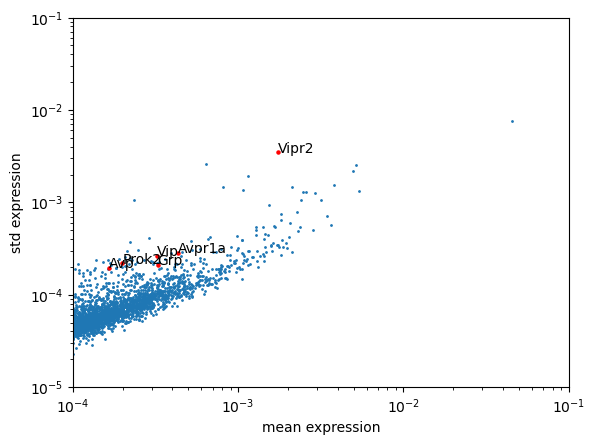

In [3]:
zonated_genes = np.array(
    ["Vip", "Avp", "Prok2", "Penk", "Vipr2", "Avpr1a", "Cck", "Grp", "Syt1"]
)
# eman expressio over the hexagons
mean_g = adata.layers["norm"].mean(axis=0)
std_g = adata.layers["norm"].std(axis=0)

plt.scatter(mean_g, std_g, s=1)


# plot in red the zonatd genes only
mean_z = mean_g[adata.var_names.isin(zonated_genes)]
std_z = std_g[adata.var_names.isin(zonated_genes)]
plt.scatter(mean_z, std_z, s=5, c="r")
# plot the zonated genes names
for i, txt in enumerate(zonated_genes):
    plt.annotate(txt, (mean_z[i], std_z[i]))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("mean expression")
plt.ylabel("std expression")

plt.xlim([1e-4, 1e-1])
plt.ylim([1e-5, 1e-1])

# fit a line to the log-log plot of mean vs std
# from scipy import stats
# slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(mean_g), np.log10(std_g))
# print("slope: %f    intercept: %f" % (slope, intercept))
# print("R-squared: %f" % r_value**2)

# # plot the line
# x = np.linspace(1e-4, 1e-1, 100)
# y = 10**(slope*np.log10(x) + intercept)

In [4]:
# take a mask of the 1000 most variable genes
mask = np.argsort(std_g)[::-1][:1000]
best_g = genes[mask]
best_g

# removing problematic genes, which have only few counts
median_best = np.median(adata[:, best_g].layers['norm'], axis=0)
best_g = best_g[median_best != 0]

In [5]:
# create a matrix with x , y and z obs from adata, joining the 3 vectors as three columns
# and then convert it to a tensor

real_coord = np.stack((adata.obs["x"], adata.obs["y"], adata.obs["z"]), axis=-1)
coord = np.stack((adata.obs["x"], adata.obs["y"], adata.obs["z"]), axis=-1)
# normalize the data
coord = (coord - coord.mean(axis=0)) / coord.std(axis=0)

xx = np.linspace(coord[:, 0].min(), coord[:, 0].max(), 1000)
yy = np.linspace(coord[:, 1].min(), coord[:, 1].max(), 1000)
zz = np.linspace(coord[:, 2].min(), coord[:, 2].max(), 1000)

# vector of variables used to plot
space = np.stack((xx, yy, zz), -1)
space


array([[-1.52578004, -2.30725508, -1.97932127],
       [-1.52205828, -2.30308561, -1.97523406],
       [-1.51833653, -2.29891614, -1.97114684],
       ...,
       [ 2.18480687,  1.84971023,  2.09563245],
       [ 2.18852862,  1.8538797 ,  2.09971967],
       [ 2.19225037,  1.85804918,  2.10380688]])

In [6]:
space_labels = np.array(["med-lat", "dors-vent", "ant-post"])

# create a vector to store the fitted parameters
# N_genes x N_space_labels x N_parameters
theta = np.zeros((len(best_g), 3, 3))
theta.shape


(993, 3, 3)

In [7]:
# eliminate genes that do no converege
NC, NG = adata.X.shape
n = NC
best_g = best_g[best_g != "Gulp1"]
best_g = best_g[best_g != "Gnrh1"]

random_best = np.random.choice(best_g, 10)
random_best


array(['Cnbp', 'Dram2', 'Ftl1', 'Trim2', 'Gm42418', 'Enpp2', 'Cyfip2',
       'Eef1a1', 'Tomm7', 'Qk'], dtype=object)

### showing all the 3 models


In [8]:
# for i, g in enumerate(random_best):
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(g)
#     for d in range(3):
#         # fit the data with the 3 models
#         # model 1
#         mean_y = np.mean(adata[:, g].layers["norm"].squeeze())
#         mse1 = LL(
#             adata[:, g].layers["norm"].squeeze(),
#             np.full_like(adata[:, g].layers["norm"].squeeze(), mean_y),
#         )
#         bic1 = calculate_bic(n, mse1, 1)

#         # model 2
#         params2, _ = curve_fit(
#             exp_line, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0)
#         )
#         y_pred2 = exp_line(coord[:, d], *params2)
#         mse2 = LL(adata[:, g].layers["norm"].squeeze(), y_pred2)
#         bic2 = calculate_bic(n, mse2, 2)

#         # model 3
#         params3, _ = curve_fit(
#             exp_parabola,
#             coord[:, d],
#             adata[:, g].layers["norm"].squeeze(),
#             p0=(0, 0, 0),
#         )
#         y_pred3 = exp_parabola(coord[:, d], *params3)
#         mse3 = LL(adata[:, g].layers["norm"].squeeze(), y_pred3)
#         bic3 = calculate_bic(n, mse3, 3)

#         # nor with sme if statement check which is the best model

#         # plot the data
#         plt.subplot(1, 3, d + 1)
#         plt.title(np.argmin([bic1, bic2, bic3]) + 1)
#         plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
#         # plot horizontal line
#         plt.axhline(mean_y, color="grey", ls="--", label=1)
#         plt.plot(space[:, d], exp_line(yy, *params2), label=bic2 / bic1)
#         plt.plot(space[:, d], exp_parabola(yy, *params3), label=bic3 / bic1)
#         # plot horizontal line
#         plt.xlabel(space_labels[d])
#         plt.legend()

random 10 genes from 1000 most expressed

In [9]:
# for i, g in enumerate(random_best):
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(g)

#     for d in range(3):
#         best, best_bic, zonated, params = analyze_gene2(adata, g, coord, d, n)

#         plt.subplot(1, 3, d + 1)
#         plt.title(best_bic)
#         plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
#         plt.plot(space[:, d], exp_parabola(yy, *params), label=best + 1, c="r")
#         # plot horizontal line
#         plt.xlabel(space_labels[d])
#         plt.legend()

In [10]:
best_g = best_g[best_g != "Cfh"]

In [11]:
# now I want to write a loop where I fill a dictionary with the parameters of the best model
# and also another dictuoary witu informations that I extract with the function analyze_gene2

# create a dictionary with the parameters
# N_genes x N_space_labels x N_parameters
theta = np.zeros((len(best_g), 3, 3))

# create a dictionary with the informations
# N_genes x N_space_labels x N_informations
info = np.zeros((len(best_g), 3, 3))

for i, g in enumerate(best_g):
    for d in range(3):
        best, best_bic, zonated, params = analyze_gene2(adata, g, coord, d, n)
        theta[i, d, :] = params
        info[i, d, :] = np.array([best, best_bic, zonated])


In [12]:
# now I go into info vector and if only one of the dimensions is zonated
# I mark the gene as zonated

zonated_genes_big = []
for i, g in enumerate(best_g):
    if np.sum(info[i, :, 2]) >= 1:
        zonated_genes_big.append(g)

zonated_genes_big.__len__()

245

In [13]:
# create a pdf file, with all 200 candidates

# with PdfPages('output.pdf') as pdf:
#     for i, g in enumerate(zonated_genes_big):
#         plt.figure(figsize=(15, 5))
#         plt.suptitle(g)

#         for d in range(3):
#             best, best_bic, zonated, params = analyze_gene2(adata, g, d)

#             plt.subplot(1, 3, d + 1)
#             plt.title(best_bic)
#             plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
#             plt.plot(space[:, d], exp_parabola(yy, *params), label=best + 1, c="r")
#             # plot horizontal line
#             plt.xlabel(space_labels[d])
#             plt.legend()
#         pdf.savefig()
#         plt.close()

In [25]:
# load zonated_list.txt 
zonated_list_final = np.loadtxt("zonated_list.txt", dtype=str)
zonated_list_final

'Vip' in zonated_list_final

True

# Fitting in 2 or 3 dimensions

Now we will use the following model:  

**2D**  
we start from Vip which is mainly zonated in directions only. acutally for vip the dims are y and z.  
in the end we want somethig: 
\begin{equation}
    \mu_i = exp( a_x x_i^2 + b_x x_i+ b_y y_i^2  +b_y y_i + c )  
\end{equation}

**3D**  
in the end we want: 
\begin{equation}
    \mu_i = exp( a_x x_i^2 + b_x x_i+ b_y y_i^2  +b_y y_i + b_z z_i^2  +b_z z_i + c )  
\end{equation}

## fitting 2D

In [26]:
# fit all the genes
yz = coord[:, [1, 2]]
theta_2D = np.zeros((len(zonated_list_final), 5))
losses_2D = np.zeros(len(zonated_list_final))
for i, g in enumerate(zonated_list_final):
    theta_2D[i, :], _ = curve_fit(
        func_2D, yz.T, adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0)
    )
    # loss
    losses_2D[i] = loss_2D(
        coord[:, [1, 2]], adata[:, g].layers["norm"], *theta_2D[i, :]
    )

In [27]:
#  create a df with the fitted parameters
df = pd.DataFrame(
    theta_2D,
    index=zonated_list_final,
    columns=["ay", "by", "az", "bz", "c"],
)
# save df to csv
df.to_csv("fit/theta_2D_big.csv")

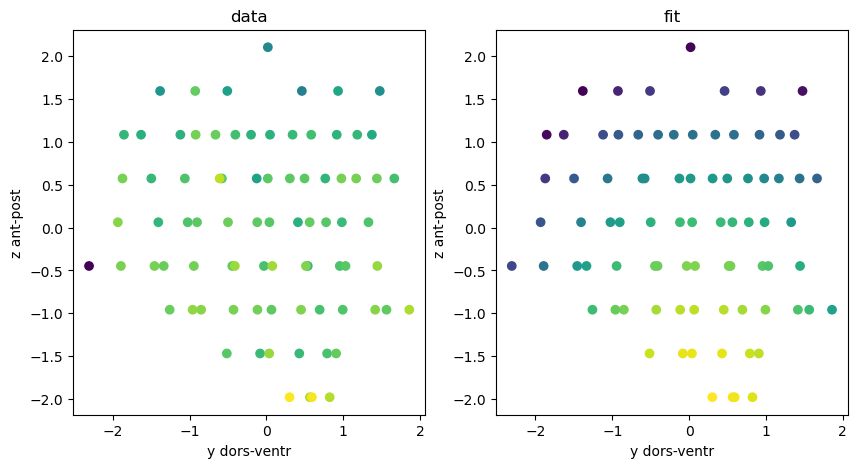

In [28]:
# fit the 2D function to the data
gene = "Gm42418"

# plot the fit SIDE BY SIDE with the data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(yz[:, 0], yz[:, 1], c=adata[:, gene].layers["norm"].squeeze())
plt.title("data")
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")

plt.subplot(1, 2, 2)
plt.scatter(
    yz[:, 0], yz[:, 1], c=func_2D(yz.T, *theta_2D[ind_z(zonated_list_final, gene), :])
)
plt.title("fit")
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")
plt.show()


## fitting 3D

Loss functions get definetly smaller

In [29]:
xyz = coord[:, [0, 1, 2]]

In [30]:
# fitting all zonated genes in 3D

# create a vector to store the fitted parameters
# N_genes x  N_parameters
theta_3D = np.zeros((len(zonated_list_final), 7))
# save losses
losses_3D = np.zeros(len(zonated_list_final))
print(theta_3D.shape)
# now fit all the zonated genes
for i, g in enumerate(zonated_list_final):
    theta_3D[i, :], _ = curve_fit(
        func_3D, xyz.T, adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0, 0, 0)
    )
    losses_3D[i] = loss_3D(xyz, adata[:, g].layers["norm"].squeeze(), *theta_3D[i, :])

(68, 7)


In [31]:
# create a df with the fitted parameters
df = pd.DataFrame(
    theta_3D,
    index=zonated_list_final,
    columns=["ax", "bx", "ay", "by", "az", "bz", "c"],
)
# save df to csv
df.to_csv("fit/theta_3D_big.csv")

Text(0, 0.5, 'loss 3D')

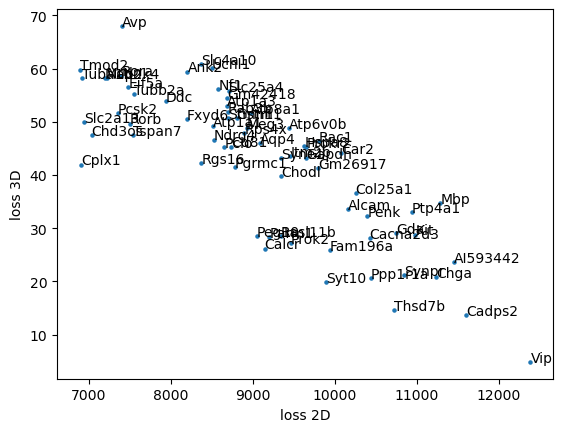

In [32]:
# scatter plot the loss values for all genes
# 2D vs 3D, also mark with ames the dots


plt.scatter(losses_2D, losses_3D, s=5)
# plot the zonated genes names from the zonated_list_final
for i, txt in enumerate(zonated_list_final):
    plt.annotate(txt, (losses_2D[i], losses_3D[i]))
plt.xlabel("loss 2D")
plt.ylabel("loss 3D")

# plt.xscale("log")
# plt.yscale("log")

(1e-05, 0.1)

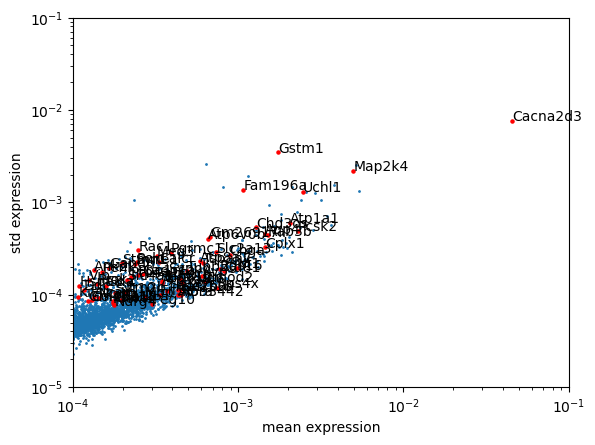

In [39]:
plt.scatter(mean_g, std_g, s=1)


# plot in red the zonatd genes only
mean_z_f = mean_g[adata.var_names.isin(zonated_list_final)]
std_z_f = std_g[adata.var_names.isin(zonated_list_final)]
plt.scatter(mean_z_f, std_z_f, s=5, c="r")
# plot the zonated genes names
for i, txt in enumerate(zonated_list_final):
    plt.annotate(txt, (mean_z_f[i], std_z_f[i]))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("mean expression")
plt.ylabel("std expression")

plt.xlim([1e-4, 1e-1])
plt.ylim([1e-5, 1e-1])